#### Imports 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

#### Importing Data

In [3]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))]) 
    tr_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return tr_df

In [4]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    ts_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return ts_df

In [5]:
tr_df = train_df(r"Data\Training")
ts_df = test_df(r"Data\Testing")

In [6]:
tr_df

,Class Path,Class
0,Data\Training\glioma\Tr-glTr_0000.jpg,glioma
1,Data\Training\glioma\Tr-glTr_0001.jpg,glioma
2,Data\Training\glioma\Tr-glTr_0002.jpg,glioma
3,Data\Training\glioma\Tr-glTr_0003.jpg,glioma
4,Data\Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Data\Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Data\Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Data\Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Data\Training\pituitary\Tr-pi_1455.jpg,pituitary


In [7]:
ts_df

,Class Path,Class
0,Data\Testing\glioma\Te-glTr_0000.jpg,glioma
1,Data\Testing\glioma\Te-glTr_0001.jpg,glioma
2,Data\Testing\glioma\Te-glTr_0002.jpg,glioma
3,Data\Testing\glioma\Te-glTr_0003.jpg,glioma
4,Data\Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Data\Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,Data\Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,Data\Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,Data\Testing\pituitary\Te-pi_0298.jpg,pituitary


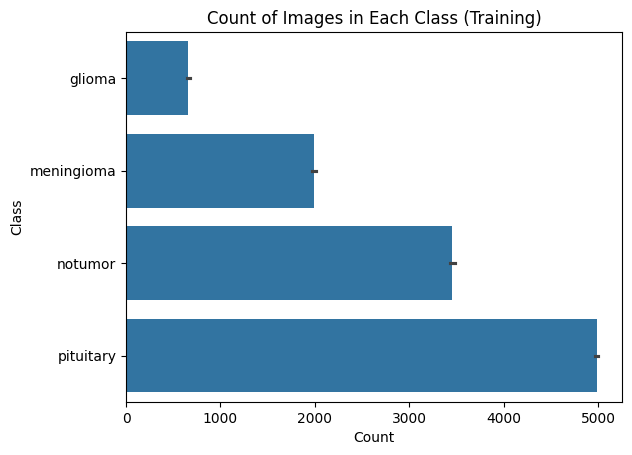

In [8]:
# Count of images in training dataset
plt.figure()
sns.barplot(tr_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Training)")
plt.show()

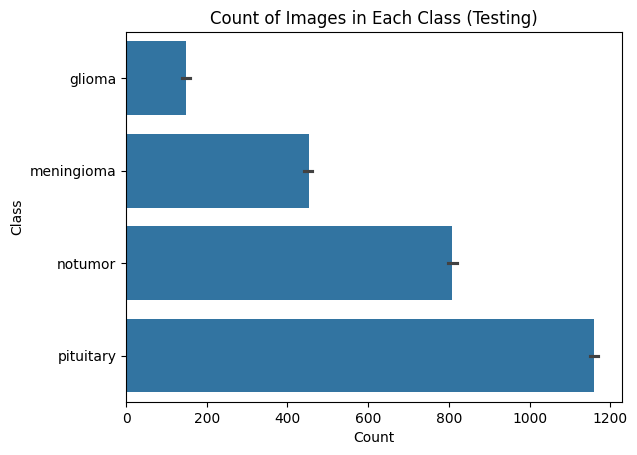

In [9]:
# Count of images in the training daaset
plt.figure()
sns.barplot(ts_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Testing)")
plt.show()

#### Data Preprocessing

In [10]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size, 
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=True)

# set shuffle equal to True simply for the picture

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [11]:
# Use annomoly detection, the notumor images to the tumor images. Could tell us where the tumor is.

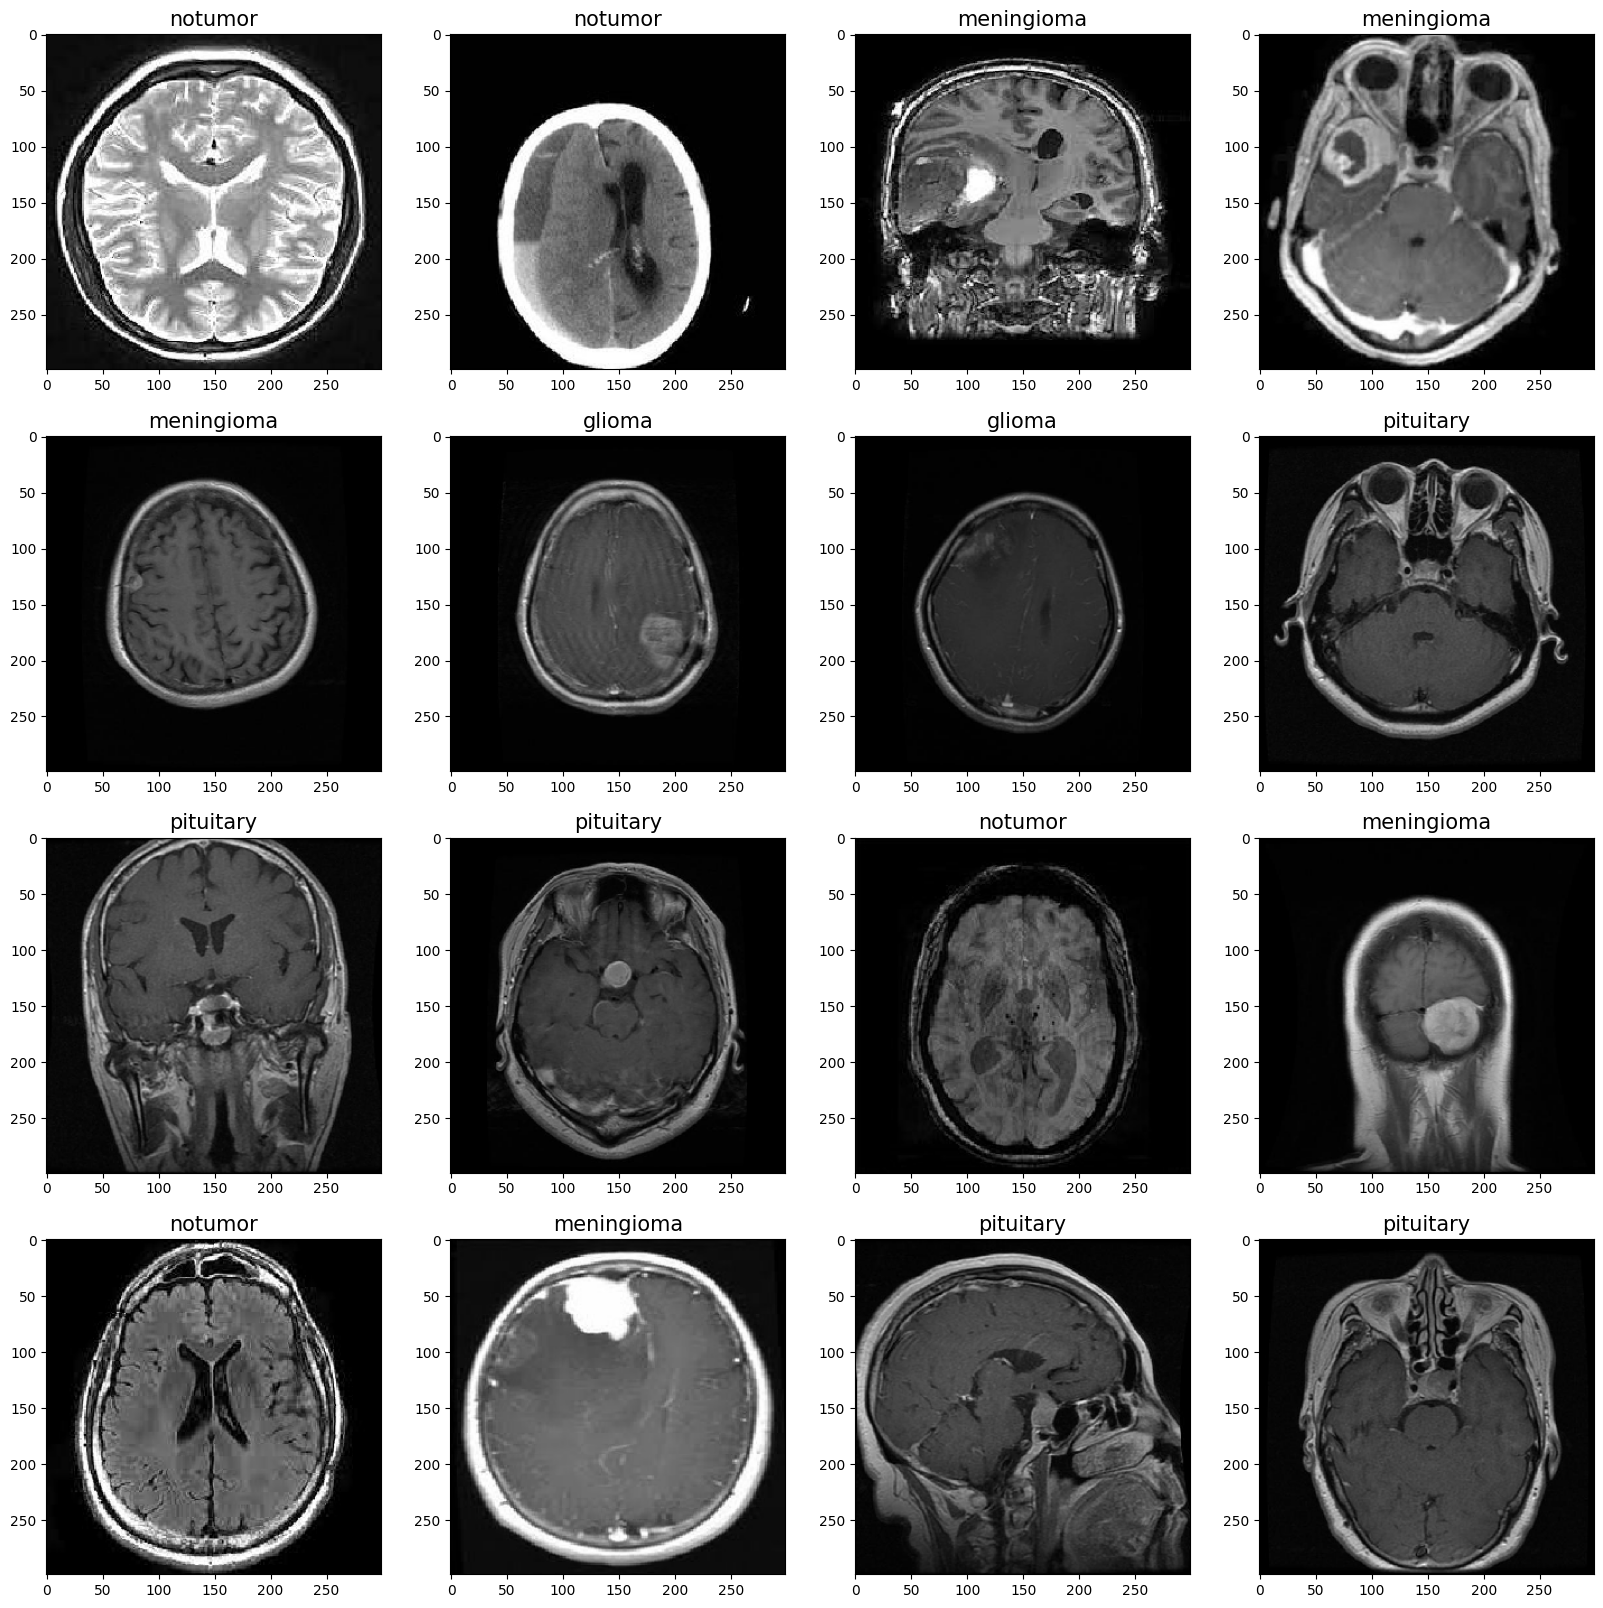

In [12]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

In [13]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size,
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=False)

# set shuffle back to false for model and confusion matrix 
# if set to true, then messes up confusion matrix as true labels 
# are also shuffled with the images. 

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

#### Initial CNN

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 138s 762ms/step - accuracy: 0.7661 - loss: 1.5737
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.9433 - loss: 0.1796
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - accuracy: 0.9872 - loss: 0.0589
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - accuracy: 0.9972 - loss: 0.0176
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - accuracy: 0.9996 - loss: 0.0054
82/82 - 28s - 346ms/step - accuracy: 0.9397 - loss: 0.1750
Loss: 0.17502151429653168
Accuracy: 0.9397406578063965


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step


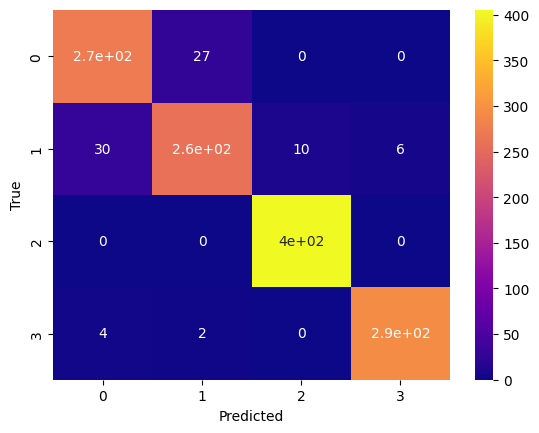

              precision    recall  f1-score   support

      glioma       0.89      0.91      0.90       300
  meningioma       0.90      0.85      0.87       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [16]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

#### Hyperparameter Tuning

In [17]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

Epoch 1/5


C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


179/179 ━━━━━━━━━━━━━━━━━━━━ 109s 605ms/step - accuracy: 0.6998 - loss: 1.8092
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 109s 607ms/step - accuracy: 0.8722 - loss: 0.3638
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 109s 607ms/step - accuracy: 0.9424 - loss: 0.1883
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 109s 607ms/step - accuracy: 0.9666 - loss: 0.1130
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 109s 606ms/step - accuracy: 0.9818 - loss: 0.0619
82/82 - 10s - 117ms/step - accuracy: 0.9260 - loss: 0.2562
Loss: 0.2561797797679901
Accuracy: 0.9260106682777405


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step


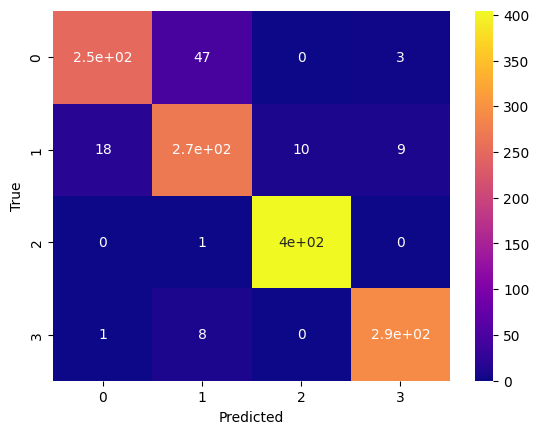

              precision    recall  f1-score   support

      glioma       0.93      0.83      0.88       300
  meningioma       0.83      0.88      0.85       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.96      0.97      0.97       300

    accuracy                           0.93      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



In [18]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

#### Anonaly Detection, autoencoders. 

In [40]:
laten_dim = 64

encoder = models.Sequential([
    layers.Conv2D(64, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.Conv2D(16, (3,3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(laten_dim*2)
], name="encoder")

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
class Sampling(layers.Layer):
    def call(self, z_params):
        
        z_mean, z_log_var = tf.split(z_params, 2, axis=1)
        # The endoder outputs (z_mean, z_log_var) stacked together,
        # this line splits them into two tensors

        eps = tf.random.normal(shape=tf.shape(z_mean))
        # Generate random noise with the same shape as z_mean
        
        return z_mean + tf.exp(0.5 * z_log_var) * eps
        # This is the reparameterization trick:
        #  - tf.exp = standard deviation
        #  - muttiply by noise to introduce randomness
        #  - add mean to shift the distribution
    
"""
Reparameterization trick is required to make the VAE trainable. 

It takes the encoder's output [z_mean, z_log_var], and uses them 
 to produce a vector to be fed into the decoder 

This needs to be done becasue VAE learns distribution, not a single point,
 the model then samples a point from this distribution

Sampling is not differentiable, and since NNs train on gradients, we need
 to rewrite the sampling in a differentiable way (z= mean + std * eps)

"""

"\nReparameterization trick is required to make the VAE trainable. \n\nIt takes the encoder's output [z_mean, z_log_var], and uses them \n to produce a vector to be fed into the decoder \n\nThis needs to be done becasue VAE learns distribution, not a single point,\n the model then samples a point from this distribution\n\nSampling is not differentiable, and since NNs train on gradients, we need\n to rewrite the sampling in a differentiable way (z= mean + std * eps)\n\n"

In [42]:
# decoder = models.Sequential([
#     layers.Dense(294*294*64, activation="relu", input_shape=(laten_dim,)),
#     layers.Reshape((294, 294, 64)),
#     layers.Conv2DTranspose(64, 2, activation="relu"),
#     layers.Conv2DTranspose(32, 2, activation="relu"),
#     layers.Conv2DTranspose(16, 2, activation="relu"),
#     layers.Conv2DTranspose(3, 3, activation="sigmoid"),
# ], name="decoder")

In [43]:
decoder = models.Sequential([
    layers.Dense(19*19*64, activation="relu", input_shape=(laten_dim,)),
    layers.Reshape((19,19,64)),
    layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2DTranspose(8, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2D(3, 3, padding="same", activation="sigmoid"),
    layers.Cropping2D(((2,3), (2,3))),
], name="decoder")

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampling()

        self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32)
    
    def train_step(self, data):
        
        x, _ = data

        self.beta.assign(tf.minimum(1.0, self.beta + 0.001))

        with tf.GradientTape() as tape:
            z_params = self.encoder(x)
            z_mean, z_log_var = tf.split(z_params, 2, axis=1)

            z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)

            z_params_clipped = tf.concat([z_mean, z_log_var], axis=1)

            z = self.sampler(z_params_clipped)

            reconstruction = self.decoder(z)

            recon_loss = tf.reduce_mean(tf.square(x -reconstruction))
            recon_loss = tf.reduce_sum(recon_loss, axis=list(range(1, len(recon_loss.shape))))
            recon_loss = tf.reduce_mean(tf.reduce_sum(recon_loss))

            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            #beta = 0.1

            total_loss = recon_loss + self.beta * kl_loss
    
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": total_loss,
                "reconstruction_loss": recon_loss,
                "kl_loss": kl_loss
                }

In [49]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(tr_gen, epochs=1, batch_size=64)

179/179 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - kl_loss: 8.8504e-06 - kl_weight: 0.1790 - loss: 0.0319 - reconstruction_loss: 0.0319


The mse loss is alright, but the kl_loss is being collapsed down to zero, nmeaning that it's getting overshadowed by the reconstruction loss, fix that by giving it a weight. Also, change the latent_dim to something bigger, maybe 16 or 32? the 2-dim sapce is too small for the images to actually learn something. 